# Importing Packages

In [49]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from arch.unitroot import PhillipsPerron as pp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
sns.set_style("whitegrid")
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

# Importing  and Filtering the Data
## Training Data

In [50]:
dt_parse = lambda dates: dt.strptime(dates, '%Y-%m-%d')

data = pd.read_csv('data/transformed/2000_2021_Brazilian_Northeast_Region_daily_MW_instantaneous_maximum_demand_series.csv',
                   header=0, names=['index','value', 'date'], parse_dates=True, index_col='index', date_parser=dt_parse)
data['value'] = data['value'].astype(float)
data['date'] = data['date'].astype('datetime64')
data = data[data['value'] > 0.0]
data['year']  = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day']   = data['date'].dt.day
data['weekday'] = data['date'].dt.weekday
data.head()

,value,date,year,month,day,weekday
index,,,,,,
2000-01-01,6205.0,2000-01-01,2000,1,1,5
2000-01-02,6797.0,2000-01-02,2000,1,2,6
2000-01-03,7024.0,2000-01-03,2000,1,3,0
2000-01-04,6921.0,2000-01-04,2000,1,4,1
2000-01-05,7025.0,2000-01-05,2000,1,5,2


## 2. Value over times

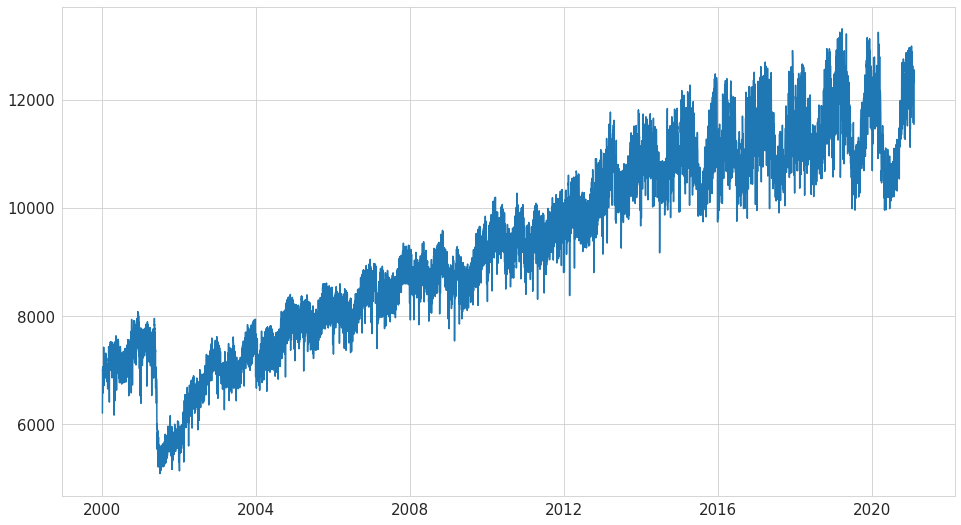

In [51]:
plt.rcParams["figure.figsize"] = [16,9]
plt.plot(data['value'])

## 2. Test Data with one hundred first values

<AxesSubplot:ylabel='Density'>

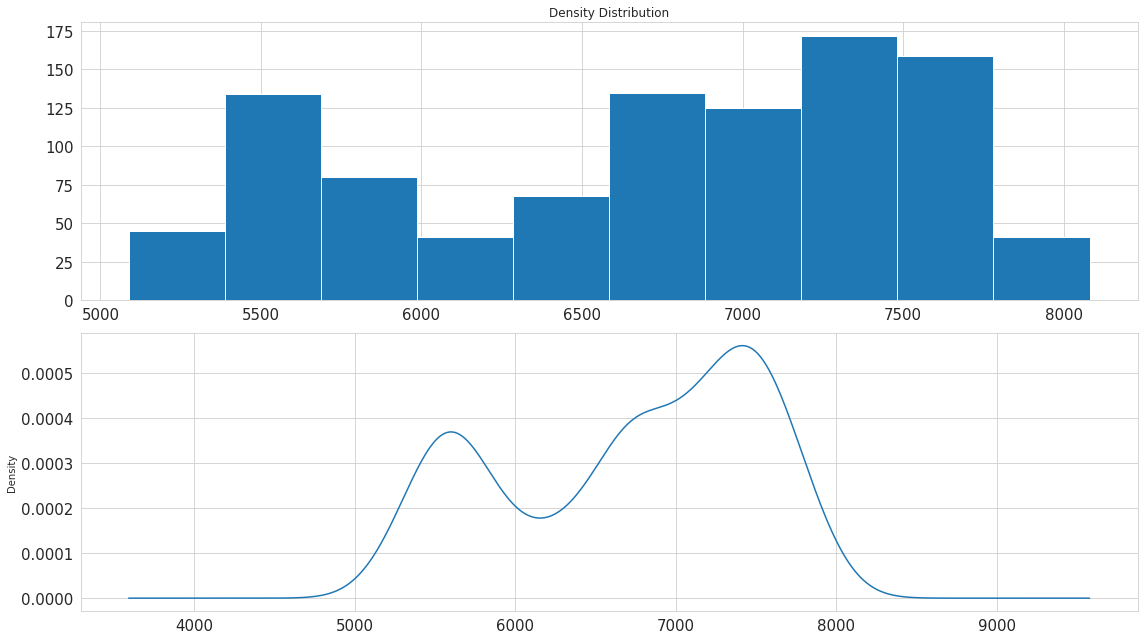

In [52]:
value = data['value'].head(1000)
plt.figure(tight_layout=True)
plt.subplot(211)
value.hist()
plt.title('Density Distribution')
plt.subplot(212)
value.plot(kind='kde')

## 2. Test Data with all values with another form

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


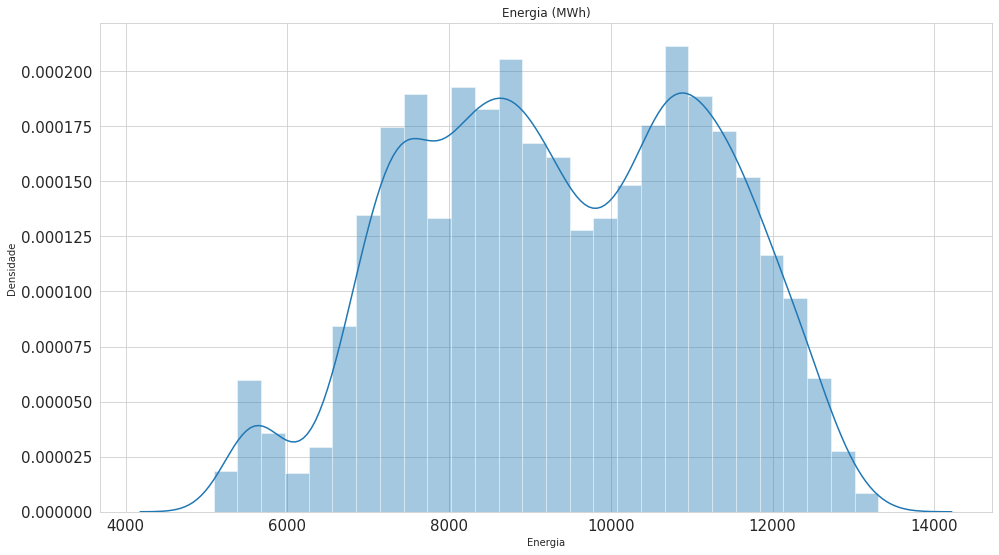

In [53]:
ax = sns.distplot(data['value'], kde=True)
ax.set(xlabel= 'Energia', ylabel='Densidade', title='Energia (MWh)')
plt.show()

## 2. Histogram

array([[<AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>],
       [<AxesSubplot:title={'center':'4'}>,
        <AxesSubplot:title={'center':'5'}>,
        <AxesSubplot:title={'center':'6'}>],
       [<AxesSubplot:title={'center':'7'}>,
        <AxesSubplot:title={'center':'8'}>,
        <AxesSubplot:title={'center':'9'}>],
       [<AxesSubplot:title={'center':'10'}>,
        <AxesSubplot:title={'center':'11'}>,
        <AxesSubplot:title={'center':'12'}>]], dtype=object)

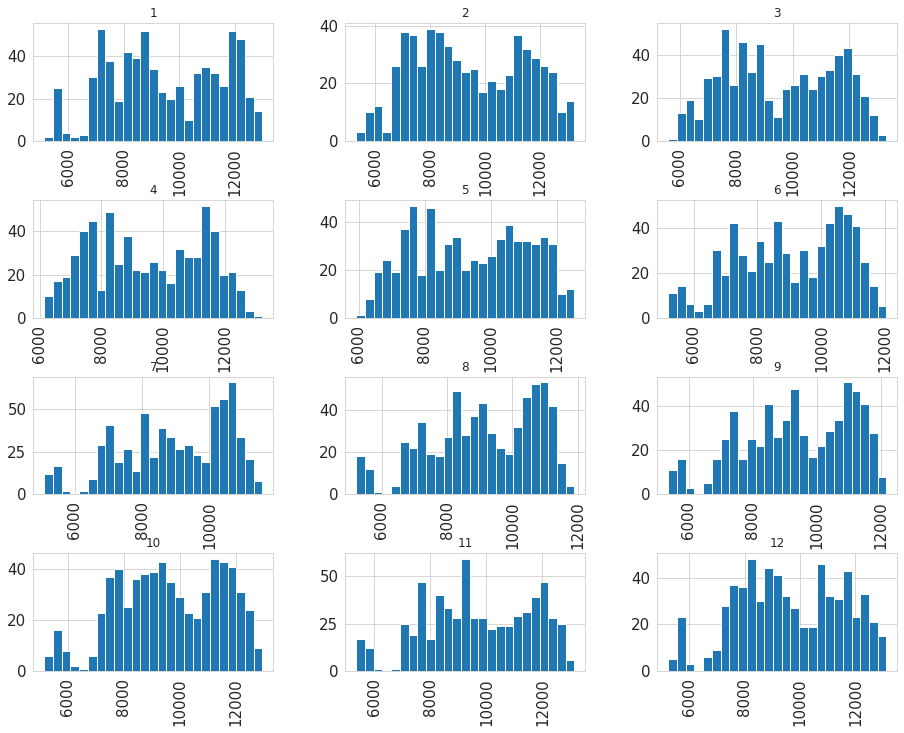

In [54]:
data.hist(figsize=(15,12), column='value', by='month', bins=25)

## 2. Box-plot

<AxesSubplot:title={'center':'value'}, xlabel='year'>

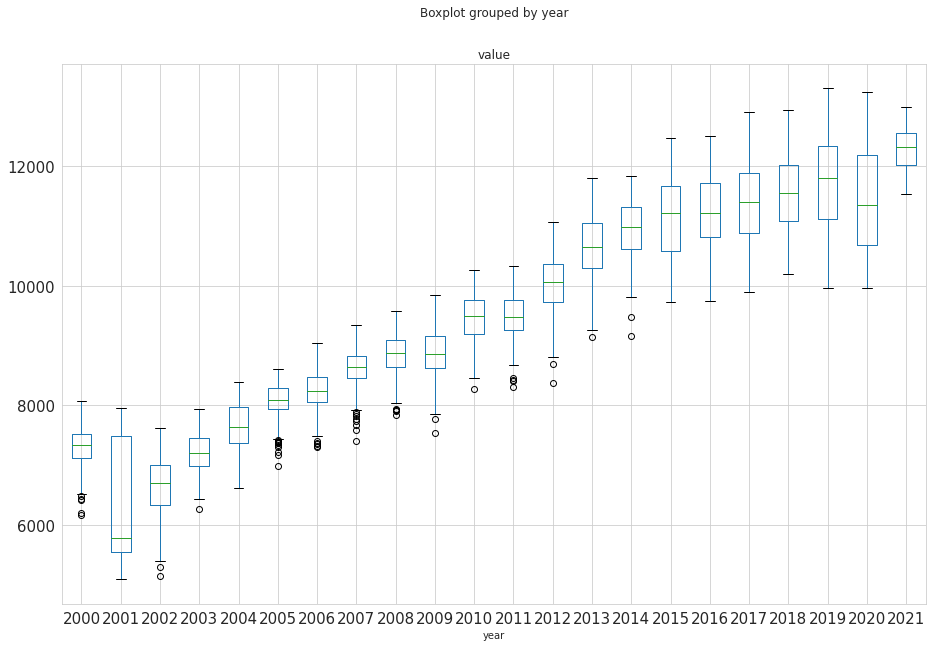

In [55]:
data.boxplot(figsize=(15,10), by='year', column='value')

## 3. Box-Cox transformation

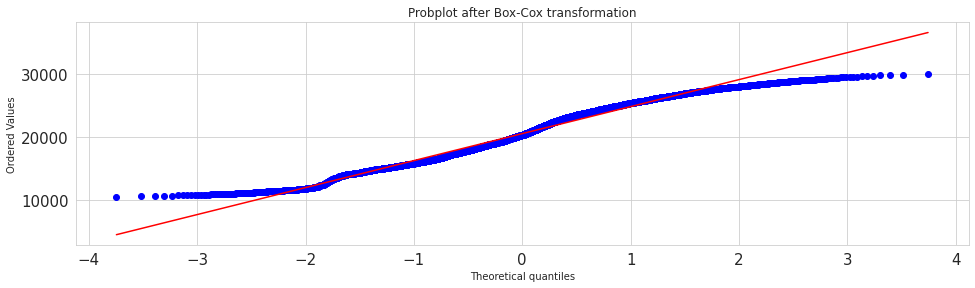

In [56]:
fig = plt.figure()
# ax1 = fig.add_subplot(211)
x = stats.loggamma.rvs(5, size=500) + 5
# prob = stats.probplot(data['value'], dist=stats.norm, plot=ax1)
# ax1.set_xlabel('')
# ax1.set_title('Probplot against normal distribution')
ax2 = fig.add_subplot(212)
xt, _ = stats.boxcox(data['value'])
prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')
plt.show()

## 3. Log transformation

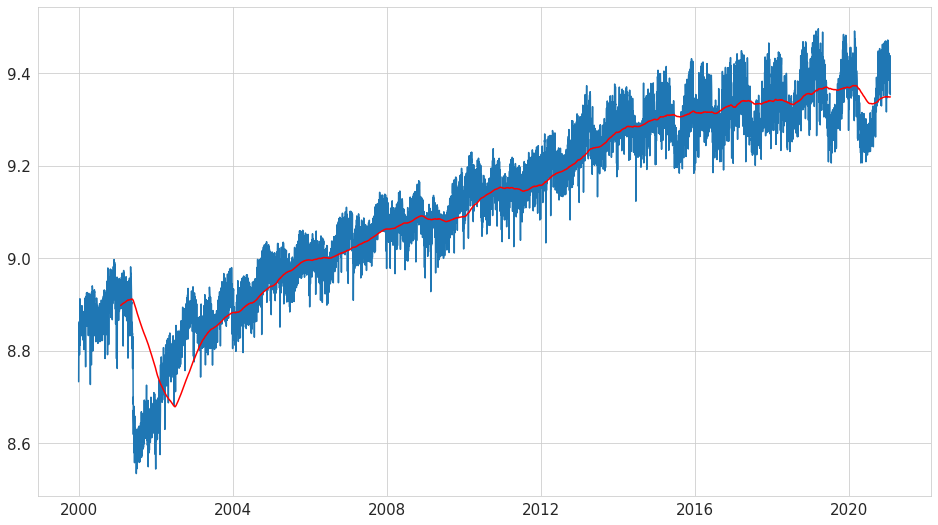

In [57]:
v_log = np.log(data['value'])
avg = v_log.rolling(400).mean()
std = v_log.rolling(400).std()
plt.plot(v_log)
plt.plot(avg, color='red')
# plt.plot(std, color='black')

# v_log = np.log(data['value'])
# data = data.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
# value = data['value']
# print(pd.infer_freq(value.index))
#
# def test_stationarity(timeseries, window_size=10000):
#
#     #Determing rolling statistics
#     rolmean = timeseries.rolling(window_size).mean()
#     rolstd  = timeseries.rolling(window_size).std()
#
#     #Plot rolling statistics:
#     plt.plot(timeseries, color='blue',label='Original')
#     plt.plot(rolmean, color='red', label='Rolling Mean')
#     plt.plot(rolstd, color='black', label = 'Rolling Std')
#     plt.legend(loc='best')
#     plt.title('Rolling Mean & Standard Deviation')
#     plt.show(block=False)
#
# test_stationarity(data['value'])
#
# #Take first difference:
# # data_diff = data['value'] - data['value'].shift()
# # plt.plot(data_diff)
# #
# # data['value'] = data_diff.values
# # data = data.replace([np.NaN, np.inf, -np.inf], 346.800)
# # data.head()
#
# test_stationarity(np.log(data['value']))

## 4. Decomposition

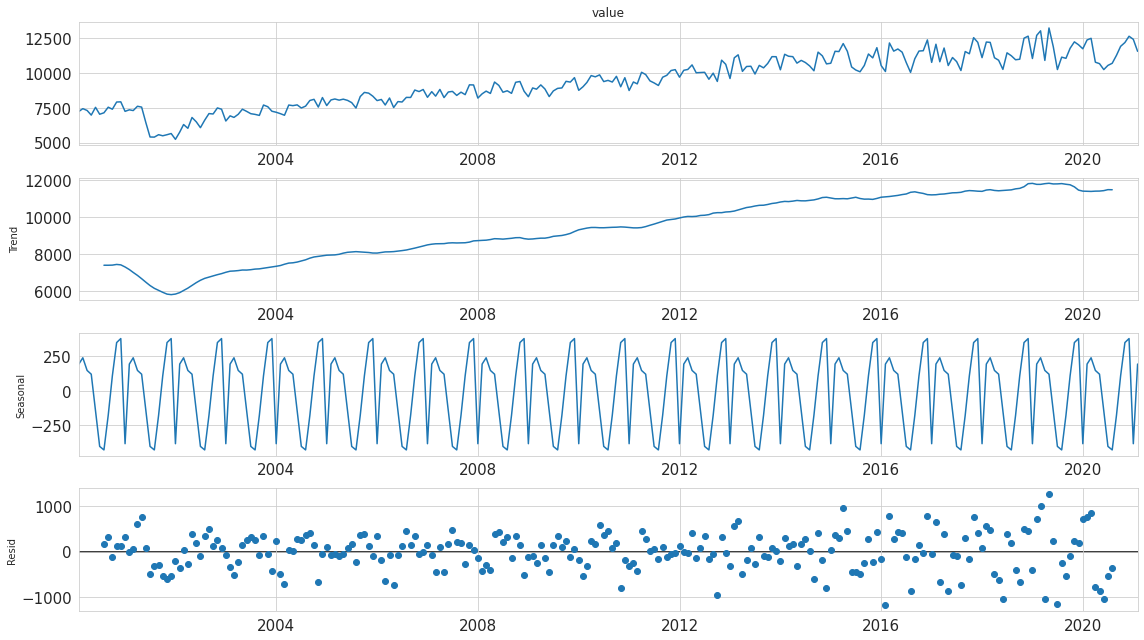

In [58]:
data.sort_index(inplace=True)
data.drop(['date', 'year', 'month', 'day', 'weekday'],inplace=True,axis=1)

decomposition = sm.tsa.seasonal_decompose(data.value.asfreq('m'), model='additive')
plt.rcParams["figure.figsize"] = [16,9]
fig = decomposition.plot()

## 5. Test KPPS

In [59]:
sm.tsa.kpss(v_log)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(19.140466151653175,
 0.01,
 36,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

## 5. Test PP

In [60]:
pp(v_log)

Test Statistic,-6.397
P-value,0.000
Lags,36


## 5. Test Fuller

In [61]:
sm.tsa.adfuller(v_log)


(-1.371008247671519,
 0.5960935347091196,
 35,
 7665,
 {'1%': -3.4312034235233315,
  '5%': -2.8619171497798384,
  '10%': -2.5669707523119336},
 -35292.93954886118)